# Disaster Tweet Classification

## Problem Overview

Social media platforms, particularly Twitter (now X), have become crucial communication channels during emergency situations. The ubiquity of smartphones enables people to report disasters and emergencies in real-time, making these platforms valuable resources for:

- **Disaster relief organizations** seeking to identify and respond to emergencies
- **News agencies** monitoring breaking news and emergency situations
- **Emergency response teams** coordinating rescue and relief efforts

## The Challenge

While Twitter provides a wealth of real-time information during disasters, distinguishing between tweets that report **actual emergencies** versus those using **metaphorical language** presents a significant challenge for automated systems.

Consider an example (from the Kaggle competition intro page) - a tweet containing the word "ABLAZE" could refer to:
- **Literal disaster**: "The building is ablaze - fire department needed!"
- **Metaphorical usage**: "The team's performance was absolutely ablaze tonight!"

While humans can easily distinguish between these contexts (especially with visual cues), machine learning models face difficulty interpreting the subtle linguistic and contextual differences that determine meaning.

## Project Objective

**Goal**: Build a machine learning model that can accurately classify tweets as either:
- **Disaster-related**: Reports of actual emergencies, disasters, or dangerous situations
- **Non-disaster**: Metaphorical usage, everyday conversations, or unrelated content

## Dataset

This project utilizes a dataset containing **10,000 tweets** that have been manually classified by human annotators. Each tweet has been labeled as either reporting a real disaster or not, providing the ground truth needed to train and evaluate our classification model.

---

## Approach

We'll explore various natural language processing (NLP) techniques and machine learning algorithms to tackle this text classification problem, including:
- Text preprocessing and feature extraction
- Deep learning methods (comparison of 2 RNN architectures)
- Model evaluation and performance optimization


In [1]:
# Import useful libraries

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2

from collections import Counter
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

import seaborn as sns
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

# Set seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

import warnings
warnings.filterwarnings('ignore')

2025-06-21 15:06:29.618244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750518389.893964      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750518389.965717      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Exploratory Data Analysis (EDA)

Before building our model, we need to understand and prepare our disaster tweet dataset.

## Objectives

### Data Analysis
- Examine dataset structure and class distribution
- Identify missing data and quality issues
- Analyze tweet characteristics and patterns

### Text Preprocessing
- Clean text (remove URLs, mentions, special characters)
- Tokenize and normalize text
- Remove stop words and apply lemmatization
- Handle Twitter-specific elements

### Model Preparation
- Prepare sequences for neural network input
- Build vocabulary and vectorize text
- Create train-validation splits

In [2]:
# Loading data
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test  = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [3]:
# Check data loaded and review
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Create reference for EDA functions
tweets = df_train

In [5]:
# Basic dataset information
print("Dataset Shape:", tweets.shape)
print("\nColumn Names:", tweets.columns.tolist())
print("\nData Types:")
print(tweets.dtypes)
print("\nMissing Values:")
print(tweets.isnull().sum())

Dataset Shape: (7613, 5)

Column Names: ['id', 'keyword', 'location', 'text', 'target']

Data Types:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Missing Values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


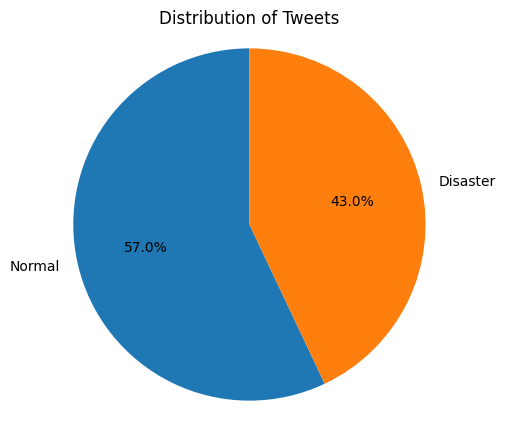

In [6]:
# Distribution of tweets
counts = df_train['target'].value_counts()
counts.index = ['Disaster' if i == 1 else 'Normal' for i in counts.index]

# Creating a pie chart
plt.figure(figsize=(5, 5))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Tweets')
plt.axis('equal')
plt.show()

In [7]:
# Display sample tweets from each class
print("\n=== SAMPLE DISASTER TWEETS ===")
disaster_tweets = tweets[tweets['target'] == 1]['text'].head(5)
for i, tweet in enumerate(disaster_tweets, 1):
    print(f"{i}. {tweet}\n")

print("=== SAMPLE NON-DISASTER TWEETS ===")
normal_tweets = tweets[tweets['target'] == 0]['text'].head(5)
for i, tweet in enumerate(normal_tweets, 1):
    print(f"{i}. {tweet}\n")


=== SAMPLE DISASTER TWEETS ===
1. Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

2. Forest fire near La Ronge Sask. Canada

3. All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected

4. 13,000 people receive #wildfires evacuation orders in California 

5. Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 

=== SAMPLE NON-DISASTER TWEETS ===
1. What's up man?

2. I love fruits

3. Summer is lovely

4. My car is so fast

5. What a goooooooaaaaaal!!!!!!



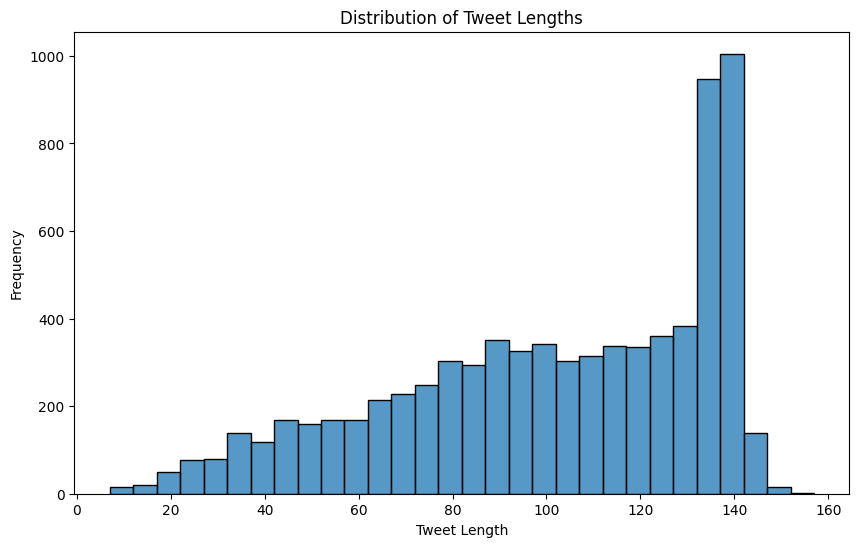

In [8]:
# Basic histogram to review tweet lengths
tweets['tweet_length'] = tweets['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(tweets['tweet_length'], bins=30, kde=False)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

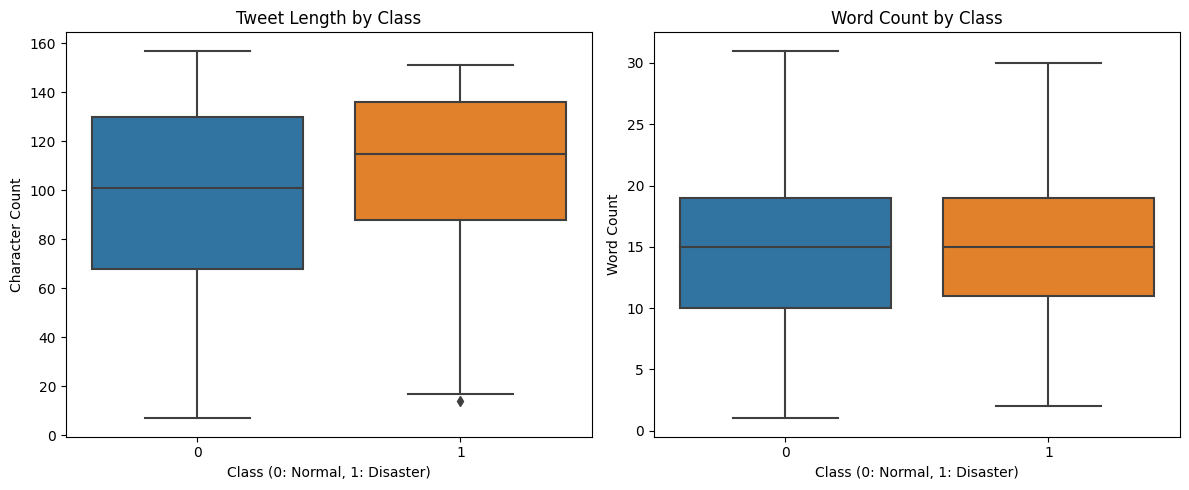

Character Length Statistics by Class:
         count        mean        std   min   25%    50%    75%    max
target                                                                
0       4342.0   95.706817  35.885924   7.0  68.0  101.0  130.0  157.0
1       3271.0  108.113421  29.309854  14.0  88.0  115.0  136.0  151.0

Word Count Statistics by Class:
         count       mean       std  min   25%   50%   75%   max
target                                                          
0       4342.0  14.704744  6.161564  1.0  10.0  15.0  19.0  31.0
1       3271.0  15.167533  5.096806  2.0  11.0  15.0  19.0  30.0


In [9]:
# Word count analysis
tweets['word_count'] = tweets['text'].apply(lambda x: len(x.split()))

# Compare tweet lengths between classes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=tweets, x='target', y='tweet_length')
plt.title('Tweet Length by Class')
plt.xlabel('Class (0: Normal, 1: Disaster)')
plt.ylabel('Character Count')

plt.subplot(1, 2, 2)
sns.boxplot(data=tweets, x='target', y='word_count')
plt.title('Word Count by Class')
plt.xlabel('Class (0: Normal, 1: Disaster)')
plt.ylabel('Word Count')

plt.tight_layout()
plt.show()

# Statistical summary by class
print("Character Length Statistics by Class:")
print(tweets.groupby('target')['tweet_length'].describe())
print("\nWord Count Statistics by Class:")
print(tweets.groupby('target')['word_count'].describe())

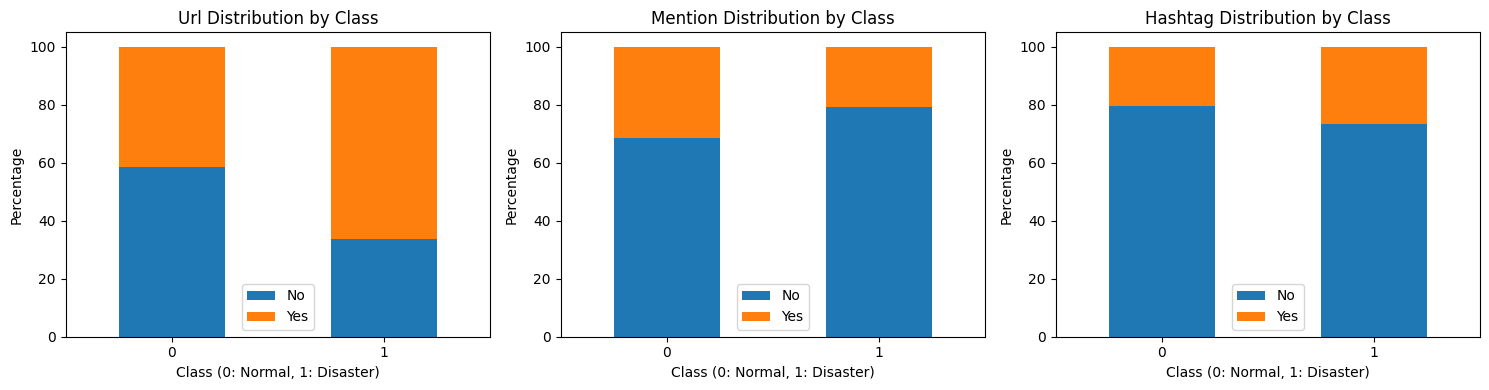

In [10]:
# Check for URLs, mentions, and hashtags
tweets['has_url'] = tweets['text'].str.contains('http', case=False, na=False)
tweets['has_mention'] = tweets['text'].str.contains('@', na=False)
tweets['has_hashtag'] = tweets['text'].str.contains('#', na=False)

# Analyze special elements by class
special_elements = ['has_url', 'has_mention', 'has_hashtag']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, element in enumerate(special_elements):
    element_counts = tweets.groupby(['target', element]).size().unstack(fill_value=0)
    element_percentages = element_counts.div(element_counts.sum(axis=1), axis=0) * 100
    
    element_percentages.plot(kind='bar', ax=axes[i], stacked=True)
    axes[i].set_title(f'{element.replace("has_", "").title()} Distribution by Class')
    axes[i].set_xlabel('Class (0: Normal, 1: Disaster)')
    axes[i].set_ylabel('Percentage')
    axes[i].legend(['No', 'Yes'])
    axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# EDA CONCLUSIONS

# Text Preprocessing and Sequence Preparation

This section will clean and prepare our tweet data for model training through the following steps:

## Preprocessing Steps

- Convert all tweets to lowercase
- Remove special characters and punctuation
- Remove stop words
- Lemmatize words to their dictionary form
- Handle URLs and user mentions

## Sequence Analysis

- Analyze word count distribution in preprocessed tweets
- Determine optimal sequence length for RNN model padding
- Assess vocabulary size for model architecture

In [11]:
# Initialize lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove all the special characters
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Replace multiple spaces with a single space
    # Lemmatization and stopword removal
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Apply cleaning function
df_train['cleaned_text'] = df_train['text'].apply(clean_text)

In [12]:
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(df_train['cleaned_text'], df_train['target'], test_size=0.2, random_state=42)

# Tokenizing text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)

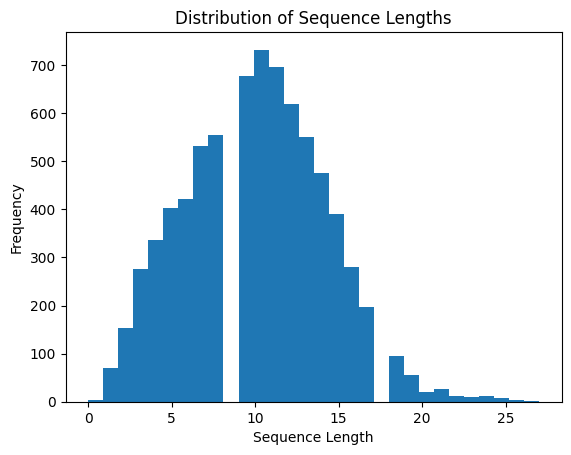

90th percentile: 15.0


In [13]:
# Analyzing the distribution of text lengths in terms of word count
sequence_lengths = [len(seq) for seq in tokenizer.texts_to_sequences(df_train['cleaned_text'])]

# Plotting the distribution
plt.hist(sequence_lengths, bins=30)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Determining a suitable `maxlen` based on percentile
import numpy as np
print("90th percentile:", np.percentile(sequence_lengths, 90))

In [14]:
# Padding sequences
X_train = pad_sequences(X_train, maxlen=15)
X_valid = pad_sequences(X_valid, maxlen=15)

# EDA - conclusion

EDA reveals several key findings:

## Dataset Characteristics
- **Class distribution**: The dataset is reasonably balanced with 43% disaster tweets and 57% non-disaster tweets
- **Tweet lengths**: Many tweets are exactly 140 characters (the former Twitter limit), though considerable variation exists
- **Word counts**: After preprocessing, most tweets contain 9-11 words
- **Sequence length**: 90% of tweets have 15 words or fewer

## Model Implications
Based on these findings, we will:
- Set the maximum sequence length to **15 words** for our models
- Use this length for padding shorter sequences
- Proceed with confidence that the data is well-suited for Recurrent Neural Network analysis

The balanced dataset and consistent sequence lengths provide a solid foundation for building an effective disaster tweet classification model.

# Model Architecture

In this section, we will evaluate two different RNN architectures to understand how model complexity affects prediction accuracy:

## Model Variants

### **Basic RNN Architecture**
A simple RNN model that serves as our baseline. This straightforward architecture will help us establish fundamental performance metrics.

### **Deep (Stacked) RNN Architecture** 
A more sophisticated model with multiple layers, including additional LSTM and dense layers. This architecture should capture more complex patterns and relationships in the text data.

## Approach

The goal is to determine whether increased model complexity translates to improved classification accuracy. By comparing a simple baseline model against a deeper architecture, we can assess:

- The benefits of additional model layers
- Whether the complexity is justified by performance gains
- The optimal balance between model sophistication and training efficiency

## Focus

This section will concentrate exclusively on architectural design. We will not explore different optimizers or regularization techniques here - those optimizations will be addressed in the next section after selecting our preferred architecture.

In [15]:
# Constants
max_words = 10000  # number of words to consider from the dataset
max_len   = 15  # sequences are padded/truncated to this length

### Model comparison functions:

In [16]:
def plot_training_history(history):
    # Get number of epochs
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training & validation accuracy values
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [17]:
def get_best_epoch_stats(model_names, histories):
    accuracies = []
    losses = []
    
    for model_name, history in zip(model_names, histories):
        # Get the index of the epoch with the highest validation accuracy
        best_epoch_index = np.argmax(history.history['val_accuracy'])
        
        # Retrieve the accuracy and loss for the best epoch
        best_epoch_accuracy = history.history['val_accuracy'][best_epoch_index]
        best_epoch_loss = history.history['val_loss'][best_epoch_index]
        
        # Append the results to the respective lists
        accuracies.append(best_epoch_accuracy)
        losses.append(best_epoch_loss)
    
    return model_names, accuracies, losses

In [18]:
def plot_model_metrics(architectures, accuracies, losses):
    # Define colors
    accuracy_color = '#5BC0BE'
    loss_color = '#4C698D'

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Plot accuracy
    axs[0].bar(architectures, accuracies, color=accuracy_color)
    axs[0].set_title('Model Accuracy', fontsize=14)
    axs[0].set_ylabel('Accuracy', fontsize=12)
    axs[0].set_ylim([0, 1])

    # Adding the text labels on the bars
    for i in range(len(accuracies)):
        axs[0].text(i, accuracies[i] + 0.02, f'{accuracies[i]:.3f}', ha='center', va='bottom', color='black')

    # Plot loss
    axs[1].bar(architectures, losses, color=loss_color)
    axs[1].set_title('Model Loss', fontsize=14)
    axs[1].set_ylabel('Loss', fontsize=12)
    axs[1].set_ylim([0, max(losses)+0.1])

    # Adding the text labels on the bars
    for i in range(len(losses)):
        axs[1].text(i, losses[i] + 0.02, f'{losses[i]:.2f}', ha='center', va='bottom', color='black')  # white text for better visibility on dark color

    # Layout adjustments
    plt.tight_layout()

    # Display the plot
    plt.show()

### Basic RNN Architecture:

In [19]:
# Define the model
model_basic = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)), 
    SimpleRNN(64), 
    Dense(1, activation='sigmoid')
])

# Create a new Adam optimizer instance for this specific model
custom_adam = Adam(learning_rate=0.0001)

# Compile the model
model_basic.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_basic = model_basic.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_basic.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

2025-06-21 15:06:52.583067: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5343 - loss: 0.6872 - val_accuracy: 0.6146 - val_loss: 0.6489
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6546 - loss: 0.6338 - val_accuracy: 0.6527 - val_loss: 0.6220
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7154 - loss: 0.5922 - val_accuracy: 0.6980 - val_loss: 0.5924
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7817 - loss: 0.5217 - val_accuracy: 0.7525 - val_loss: 0.5187
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8343 - loss: 0.4112 - val_accuracy: 0.7735 - val_loss: 0.4879
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8748 - loss: 0.3344 - val_accuracy: 0.7787 - val_loss: 0.4843
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8954 - loss: 0.2830 - val_accuracy: 0.7800 - val_loss: 0.4890
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9125 - loss: 0.2416 - val_accuracy: 0.7827 - v

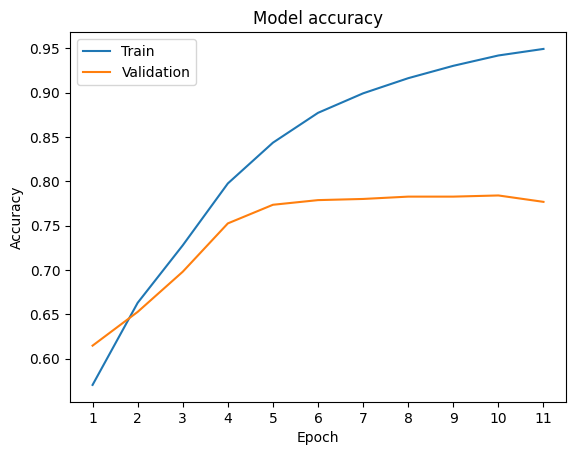

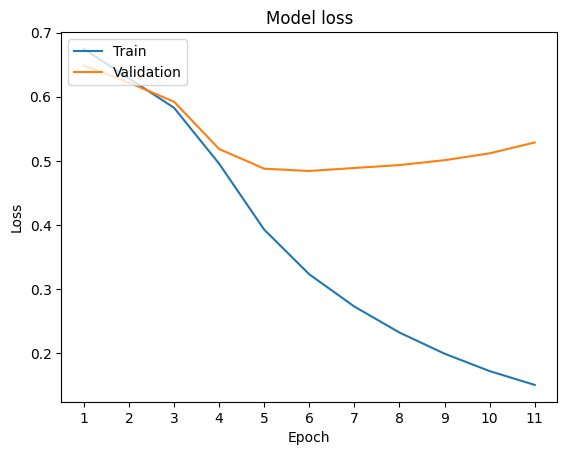

In [20]:
plot_training_history(history_basic)

### Deep (Stacked) RNN Architecture:

In [21]:
# Constructing the model
model_deep = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)), # max_len
    LSTM(128, return_sequences=True),  # First LSTM layer, returns sequences to feed into next LSTM layer
    LSTM(64, return_sequences=False),  # Second LSTM layer, does not need to return sequences
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Create a new Adam optimizer instance for this specific model
custom_adam = Adam(learning_rate=0.0001)

# Compile the model
model_deep.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_deep = model_deep.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_deep.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.5558 - loss: 0.6885 - val_accuracy: 0.5745 - val_loss: 0.6578
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5846 - loss: 0.6578 - val_accuracy: 0.6297 - val_loss: 0.6432
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6537 - loss: 0.6387 - val_accuracy: 0.6756 - val_loss: 0.6201
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.7140 - loss: 0.5995 - val_accuracy: 0.7446 - val_loss: 0.5508
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8163 - loss: 0.4588 - val_accuracy: 0.7997 - val_loss: 0.4432
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8653 - loss: 0.3251 - val_accuracy: 0.7971 - val_loss: 0.4511
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8856 - loss: 0.2806 - val_accuracy: 0.8135 - val_loss: 0.4587
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9037 - loss: 0.2437 - val_accuracy: 0.8070 - v

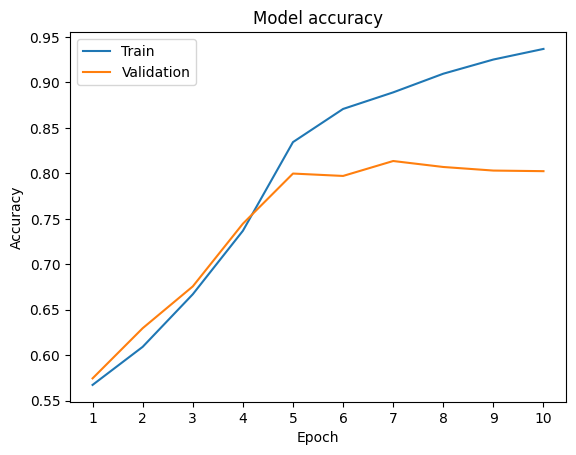

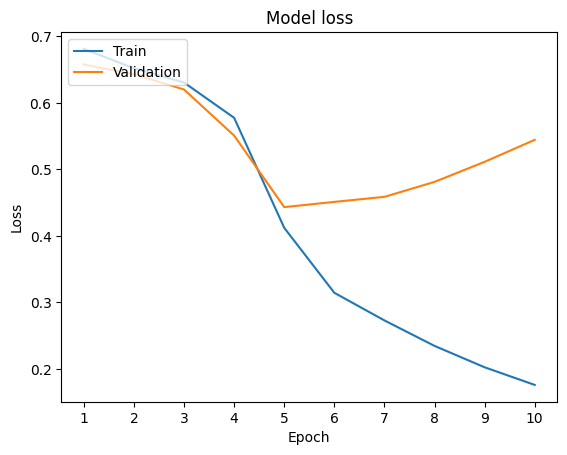

In [22]:
plot_training_history(history_deep)

### Comparison:

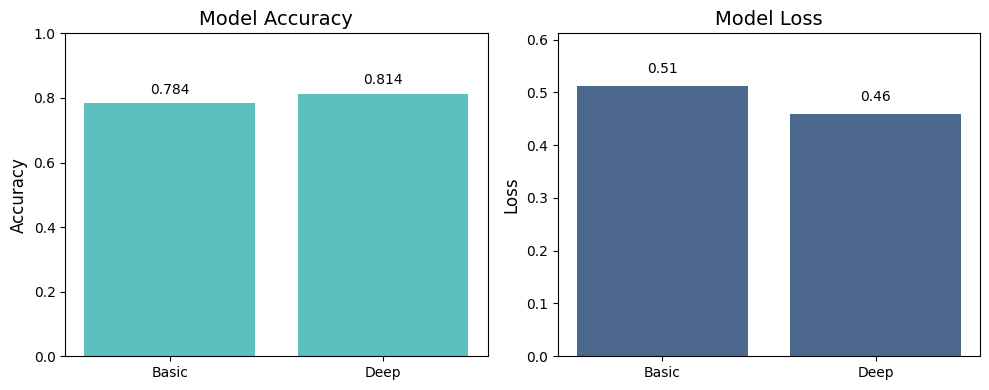

In [23]:
best = get_best_epoch_stats( ('Basic', 'Deep'), (history_basic, history_deep)  )
plot_model_metrics(*best)

## Results Summary

The deep architecture shows improved performance over the basic model:

- **Accuracy**: Deep model achieves 81.4% vs. 78.4% for the basic model (+3.0% improvement)
- **Loss**: Deep model has lower loss at 0.46 vs. 0.51 for the basic model

## Key Findings

- The additional layers in the deep architecture provide meaningful performance gains
- Both models achieve reasonable accuracy levels for disaster tweet classification
- The deep model's lower loss indicates better optimization and learning
- The 3% accuracy improvement suggests the added complexity is justified

On the basis of the deep model's outperformance, we will review model regularization factors to see if further performance improvement can be achieved...

### L2 Regularisation to improve the Deep model:

In [24]:
# Set the L2 regularization factor
l2_reg = 0.0001  # This is an example value and can be adjusted based on the needs

# Constructing the model with L2 regularization
model_deep_l2_0001 = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)), # max_len
    LSTM(128, return_sequences=True, kernel_regularizer=l2(l2_reg)),  # First LSTM layer with L2 regularization
    LSTM(64, return_sequences=False, kernel_regularizer=l2(l2_reg)),  # Second LSTM layer with L2 regularization
    Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),  # Dense layer with L2 regularization
    Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))  # Output layer with L2 regularization
])

# Create a new Adam optimizer instance for this specific model
custom_adam = Adam(learning_rate=0.0001)

# Compile the model
model_deep_l2_0001.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_deep_l2_0001 = model_deep_l2_0001.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_deep_l2_0001.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.5573 - loss: 0.7339 - val_accuracy: 0.5929 - val_loss: 0.7125
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6039 - loss: 0.7034 - val_accuracy: 0.6290 - val_loss: 0.6812
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6529 - loss: 0.6730 - val_accuracy: 0.6710 - val_loss: 0.6502
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.7225 - loss: 0.6169 - val_accuracy: 0.7748 - val_loss: 0.5333
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.8281 - loss: 0.4595 - val_accuracy: 0.7971 - val_loss: 0.4864
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.8684 - loss: 0.3586 - val_accuracy: 0.8043 - val_loss: 0.4880
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8914 - loss: 0.3186 - val_accuracy: 0.8089 - val_loss: 0.4996
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9016 - loss: 0.2939 - val_accuracy: 0.8089 - 

In [25]:
# Set the L2 regularization factor
l2_reg = 0.001  # This is an example value and can be adjusted based on the needs

# Constructing the model with L2 regularization
model_deep_l2_001 = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)), # max_len
    LSTM(128, return_sequences=True, kernel_regularizer=l2(l2_reg)),  # First LSTM layer with L2 regularization
    LSTM(64, return_sequences=False, kernel_regularizer=l2(l2_reg)),  # Second LSTM layer with L2 regularization
    Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),  # Dense layer with L2 regularization
    Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))  # Output layer with L2 regularization
])

# Create a new Adam optimizer instance for this specific model
custom_adam = Adam(learning_rate=0.0001)

# Compile the model
model_deep_l2_001.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_deep_l2_001 = model_deep_l2_001.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_deep_l2_001.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.5706 - loss: 1.1185 - val_accuracy: 0.5772 - val_loss: 1.0536
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5918 - loss: 1.0431 - val_accuracy: 0.6211 - val_loss: 0.9995
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.6406 - loss: 0.9869 - val_accuracy: 0.6619 - val_loss: 0.9460
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.7025 - loss: 0.9211 - val_accuracy: 0.7275 - val_loss: 0.8596
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.8027 - loss: 0.7678 - val_accuracy: 0.7938 - val_loss: 0.7341
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8615 - loss: 0.6043 - val_accuracy: 0.8037 - val_loss: 0.7049
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8845 - loss: 0.5321 - val_accuracy: 0.8050 - val_loss: 0.7055
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9026 - loss: 0.4796 - val_accuracy: 0.8050 - 

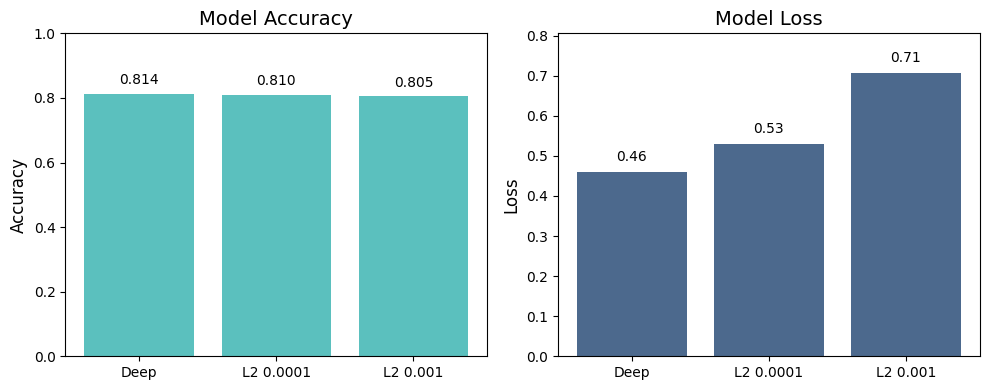

In [26]:
best = get_best_epoch_stats( ('Deep', 'L2 0.0001', 'L2 0.001'), (history_deep, history_deep_l2_0001, history_deep_l2_001)  )
plot_model_metrics(*best)

## Results Summary

Comparing the deep model with L2 regularization variants:

- **Deep (no regularization)**: 81.4% accuracy, 0.46 loss
- **L2 0.0001**: 81.0% accuracy, 0.53 loss  
- **L2 0.001**: 80.5% accuracy, 0.71 loss

## Key Findings

- **L2 regularization reduces performance**: Both regularized models show lower accuracy than the original
- **Stronger regularization = worse performance**: Higher L2 values (0.001) lead to greater accuracy drops
- **Loss increases with regularization**: Loss values rise significantly with stronger regularization

## Conclusion

For this disaster tweet classification task, L2 regularization appears to be counterproductive. The original deep model without regularization achieves the best performance, suggesting the model is not overfitting and doesn't benefit from additional constraints. The dataset may be well-suited to the model complexity without requiring regularization.

### Kaggle submission:

In [27]:
def predict_text(df, tokenizer, model, max_len):
    # Ensure text column is string type
    df['cleaned_text'] = df['cleaned_text'].astype(str)

    # Tokenize and pad the text data
    sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
    padded_sequences = pad_sequences(sequences, maxlen=max_len)

    # Predict using the RNN model
    predictions = model.predict(padded_sequences)

    # Convert predictions to binary
    df['target'] = (predictions > 0.5).astype(int)

    return df

In [28]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [29]:
df_test['cleaned_text'] = df_test['text'].apply(clean_text)
df_kaggle = predict_text(df_test, tokenizer, model_deep, max_len=15)
df_kaggle = df_kaggle[['id', 'target']]
df_kaggle

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [30]:
df_kaggle.to_csv('/kaggle/working/submission.csv', index=False)

# Conclusion

We successfully built an RNN model that can classify disaster tweets with somewhat reasonable accuracy. Further regularization of that model was counter-productive.

## Key Result

Our best model achieved **80% accuracy** on the validation set, effectively distinguishing between real disaster reports and non-disaster tweets

## Summary

This project demonstrates that RNN models can reliably identify disaster-related content in social media text, making them useful for emergency response and monitoring applications.